# Generation of Videos with Amazon Nova Models

In this notebook we will demonstrate how to use the [Amazon Nova](https://aws.amazon.com/ai/generative-ai/nova/) models for the creation of videos.

To execute the cells in this notebook you need to enable access to the following models on Bedrock:

* Amazon Nova Pro
* Amazon Nova Reel

see [Add or remove access to Amazon Bedrock foundation models](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access-modify.html) to manage the access to models in Amazon Bedrock.

## Video Generation with Amazon Nova Reel Model

First lets import the libraries

In [ ]:
import random
import time
import boto3

import base64

### Generate a video based on **text**
**Using Bedrock `start_async_invoke()` API (using boto3)**

You need to specify the region, a S3 bucket destination to store the video and text prompt.
The only allowed duration is 6 seconds, with 24 fps (frames per second) and resolution of 1280x720. You can specify a seed to reproduce results.

The videos take 5 minutes to generate

In [ ]:
seed=random.randint(0, 2147483648) # Setting a value for the seed
print(seed)

This cell will last around 5min. We will wait till the request is in *Completed* state.

In [ ]:
AWS_REGION = "us-east-1"
MODEL_ID = "amazon.nova-reel-v1:0"
SLEEP_TIME = 30
S3_DESTINATION_BUCKET = "bedrock-video-generation-us-east-1-y5s9fj"

video_prompt = "Closeup of a large seashell in the sand. Gentle waves flow all around the shell. Sunset light. Camera zoom in very close."

bedrock_runtime = boto3.client("bedrock-runtime", region_name=AWS_REGION)
model_input = {
    "taskType": "TEXT_VIDEO",
    "textToVideoParams": {"text": video_prompt},
    "videoGenerationConfig": {
        "durationSeconds": 6,
        "fps": 24,
        "dimension": "1280x720",
        "seed": seed
    }
}

invocation = bedrock_runtime.start_async_invoke(
    modelId=MODEL_ID,
    modelInput=model_input,
    outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{S3_DESTINATION_BUCKET}"}}
)

invocation_arn = invocation["invocationArn"]
s3_prefix = invocation_arn.split('/')[-1]
s3_location = f"s3://{S3_DESTINATION_BUCKET}/{s3_prefix}"
print(f"\nS3 URI: {s3_location}")

while True: # Waiting till the video is available in S3
    response = bedrock_runtime.get_async_invoke(
        invocationArn=invocation_arn
    )
    status = response["status"]
    print(f"Status: {status}")
    if status != "InProgress":
        break
    time.sleep(SLEEP_TIME)

if status == "Completed":
    print(f"\nVideo is ready at {s3_location}/output.mp4")
else:
    print(f"\nVideo generation status: {status}")

Once the status is Completed we need to download from the S3 bucket to our working directory

In [ ]:
!aws s3 cp s3://{S3_DESTINATION_BUCKET}/{s3_prefix}/output.mp4 ./videos/output-from-text.mp4
# Descargar con boto3
# Función nativa de S3
#S3Downloader.download(f”s3://{S3_BUCKET}/{S3_IMAGES_FOLDER}/image_{image_index}.png”, f”./sample_images/truck_images/raw_images”, sagemaker_session=sm_session)

With the function `Video` we can visualize videos in the jupyter notebook.

In [ ]:
from IPython.display import Video

Video("output-from-text.mp4")

### Generate a video based on **text and image**
**Using Bedrock`start_async_invoke()`(from boto3)**

For this example we require an aditional image to generate the video.

In [ ]:
input_image_name = "seascape"
input_image_path = f"images/{input_image_name}.png"
video_prompt = "drone view flying over a coastal landscape"

# Load the input image as a Base64 string.
with open(input_image_path, "rb") as f:
    input_image_bytes = f.read()
    input_image_base64 = base64.b64encode(input_image_bytes).decode("utf-8")

model_input = {
    "taskType": "TEXT_VIDEO",
    "textToVideoParams": {
        "text": video_prompt,
        "images": [{ "format": "png", "source": { "bytes": input_image_base64 } }]
        },
    "videoGenerationConfig": {
        "durationSeconds": 6,
        "fps": 24,
        "dimension": "1280x720",
        "seed": seed
    }
}

invocation = bedrock_runtime.start_async_invoke(
    modelId=MODEL_ID,
    modelInput=model_input,
    outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{S3_DESTINATION_BUCKET}"}}
)

invocation_arn = invocation["invocationArn"]
s3_prefix = invocation_arn.split('/')[-1]
s3_location = f"s3://{S3_DESTINATION_BUCKET}/{s3_prefix}"

print(f"\nS3 URI: {s3_location}")

while True: # Waiting till the video is available in S3
    response = bedrock_runtime.get_async_invoke(
        invocationArn=invocation_arn
    )
    status = response["status"]
    print(f"Status: {status}")
    if status != "InProgress":
        break
    time.sleep(SLEEP_TIME)
if status == "Completed":
    print(f"\nVideo is ready at {s3_location}/output.mp4")
else:
    print(f"\nVideo generation status: {status}")

In [ ]:
!aws s3 cp {s3_location}/output.mp4 ./videos/output.mp4

In [ ]:
Video("output.mp4")

In [4]:
import random
import time
import boto3

import base64

from IPython.display import Video

import os


In [5]:
AWS_REGION = "us-east-1"
bedrock_runtime = boto3.client("bedrock-runtime", region_name=AWS_REGION)
seed=random.randint(0, 2147483648)
print(seed)

1585649277


### Auxiliary Function to Generate Videos
Here we provide a function to generalize the video generation for text and image.

This function will generate the video from text or text + image, if we provide the image path.

In [6]:
def generate_video(
        video_prompt:str,
        seed:int,
        output_video_name:str = "output",
        input_image_name:str = "",
        S3_DESTINATION_BUCKET:str = "bedrock-video-generation-us-east-1-y5s9fj",
        AWS_REGION:str = "us-east-1",
        overwrite:bool=False,
)-> Video:
    """
    Generate a video using Amazon Nova Reel model on demand, store it on Amazon S3, download it to the workspace and then visualize it in the notebook.
    Args:
        video_prompt (str): The text prompt to use.
        seed (int): The random seed to use.
        output_video_name (str): The name to store the video.
        input_image_name (str): If provided, the image name to generate the video.
        S3_DESTINATION_BUCKET (str): The S3 bucket to store the video.
        AWS_REGION (str): The AWS Region to use.
        overwrite (bool): By default False, it won't generate another video with the same name. If set to True, it will overwrite the video.
    Returns:
        The visualization of the video
    """
    input_image_path = f"images/{input_image_name}.png"
    output_video_path = f"videos/{output_video_name}.mp4"
    
    MODEL_ID = "amazon.nova-reel-v1:0"
    SLEEP_TIME = 30

    if input_image_path != "" and os.path.isfile(input_image_path):
        with open(input_image_path, "rb") as f:
            input_image_bytes = f.read()
            input_image_base64 = base64.b64encode(input_image_bytes).decode("utf-8")

        model_input = {
            "taskType": "TEXT_VIDEO",
            "textToVideoParams": {
                "text": video_prompt,
                "images": [{ "format": "png", "source": { "bytes": input_image_base64 } }]
                },
            "videoGenerationConfig": {
                "durationSeconds": 6,
                "fps": 24,
                "dimension": "1280x720",
                "seed": random.randint(0, 2147483648)
            }
        }
    else:

        model_input = {
            "taskType": "TEXT_VIDEO",
            "textToVideoParams": {"text": video_prompt},
            "videoGenerationConfig": {
                "durationSeconds": 6,
                "fps": 24,
                "dimension": "1280x720",
                "seed": seed
            }
        }

    if os.path.isfile(output_video_path) and not overwrite:
        print("File exists")
    else:
        print("File does not exist")

        invocation = bedrock_runtime.start_async_invoke(
            modelId=MODEL_ID,
            modelInput=model_input,
            outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{S3_DESTINATION_BUCKET}"}}
        )

        invocation_arn = invocation["invocationArn"]
        s3_prefix = invocation_arn.split('/')[-1]
        s3_location = f"s3://{S3_DESTINATION_BUCKET}/{s3_prefix}"
        print(f"\nS3 URI: {s3_location}")

        while True:
            response = bedrock_runtime.get_async_invoke(
                invocationArn=invocation_arn
            )
            status = response["status"]
            print(f"Status: {status}")
            if status != "InProgress":
                break
            time.sleep(SLEEP_TIME)

        if status == "Completed":
            print(f"\nVideo is ready at {s3_location}/output.mp4")
        else:
            print(f"\nVideo generation status: {status}")

        !aws s3 cp s3://{S3_DESTINATION_BUCKET}/{s3_prefix}/output.mp4 .{output_video_path}

    return Video(output_video_path)

An example of how to use `generate_video` function. Testing if the model can generate videos using spanish (remember that documentation suggests using english only).

In [7]:
generate_video("Primer plano de un caparazón en la arena. Las olas suaves fluyen por todo el caparazón. Con luz del atardecer. Acercamiento de cámara lento.",seed=seed,output_video_name="caparazon")

File exists


An example of how to use the `generate_video`function with an image as source

In [8]:
generate_video("vista de dron volando sobre un paisaje costero",seed=seed,input_image_name='seascape', output_video_name="costa")

File exists


In [9]:
video_prompt = """
Show a quick, vibrant shot of a steaming cup of coffee with aromatic steam, placed on a cozy, rustic table with a warm, inviting coffee shop background,
accompanied by the sound of a coffee machine and soft, uplifting music
"""
generate_video(video_prompt = video_prompt, seed=seed, output_video_name='coffee_shop')


File exists


## Video Generation with Amazon Nova Canvas and Amazon Nova Reel Models

In this section we will show how to generate an image, using Amazon Nova Canvas model, to then use it to generate the video with Amazon Nova Reel model.

### Auxiliary Functions to Generate Images and Variations

First let's define a couple of functions to help us generate images and variations

In [10]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
Shows how to generate an image from a text prompt with the Amazon Nova Canvas model (on demand).
"""
import base64
import io
import json
import boto3
from PIL import Image
from botocore.config import Config

from botocore.exceptions import ClientError

class ImageError(Exception):
    "Custom exception for errors returned by Amazon Nova Canvas"

    def __init__(self, message):
        self.message = message

def generate_image_(model_id, body):
    """
    Generate an image using Amazon Nova Canvas model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    bedrock = boto3.client(
        service_name='bedrock-runtime',
        config=Config(read_timeout=300)
    )

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())

    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode('ascii')
    image_bytes = base64.b64decode(base64_bytes)

    finish_reason = response_body.get("error")

    if finish_reason is not None:
        raise ImageError(f"Image generation error. Error is {finish_reason}")

    return image_bytes

def generate_image(prompt, seed, output_image_name, overwrite=False):
    output_image_path=f"images/{output_image_name}.png"
    if os.path.isfile(output_image_path) and not overwrite:
        print("File exists")
        image = Image.open(output_image_path)
        return image
    else:
        print("File does not exist")

        model_id = 'amazon.nova-canvas-v1:0'

        body = json.dumps({
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": prompt
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 720, #Important!
                "width": 1280, #Important!
                "cfgScale": 8.0,
                "seed": seed
            }
        })

        try:
            image_bytes = generate_image_(model_id=model_id,
                                            body=body)
            image = Image.open(io.BytesIO(image_bytes))
            #image.show()
            image.save(output_image_path)
            return image

        except ClientError as err:
            message = err.response["Error"]["Message"]
            print("A client error occured: " +
                    format(message))
        except ImageError as err:
            print(err.message)

        else:
            print(
                f"Finished generating image with Amazon Nova Canvas  model {model_id}.")
            
def generate_image_variation(prompt, seed, input_image_name, output_image_name, overwrite=False, similarityStrength=0.7, negativeText= ""):
    input_image_path = f"images/{input_image_name}.png" 
    output_image_path=f"images/{output_image_name}.png"
    if os.path.isfile(output_image_path) and not overwrite:
        print("File exists")
        image = Image.open(output_image_path)
        return image
    else:

        model_id = 'amazon.nova-canvas-v1:0'

        # Read image from file and encode it as base64 string.
        with open(input_image_path, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')

        body = json.dumps({
            "taskType": "IMAGE_VARIATION",
            "imageVariationParams": {
                "text": prompt,
                "negativeText": negativeText,
                "images": [input_image],
                "similarityStrength": similarityStrength,  # Range: 0.2 to 1.0
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 720,
                "width": 1280,
                "cfgScale": 8.0,
                "seed":seed
            }
        })

        image_bytes = generate_image_(model_id=model_id,
                                        body=body)
        image = Image.open(io.BytesIO(image_bytes))
        #image.show()
        image.save(output_image_path)
        return image
    

This is an example of how to use `generate_image`function to generate an image.

File exists


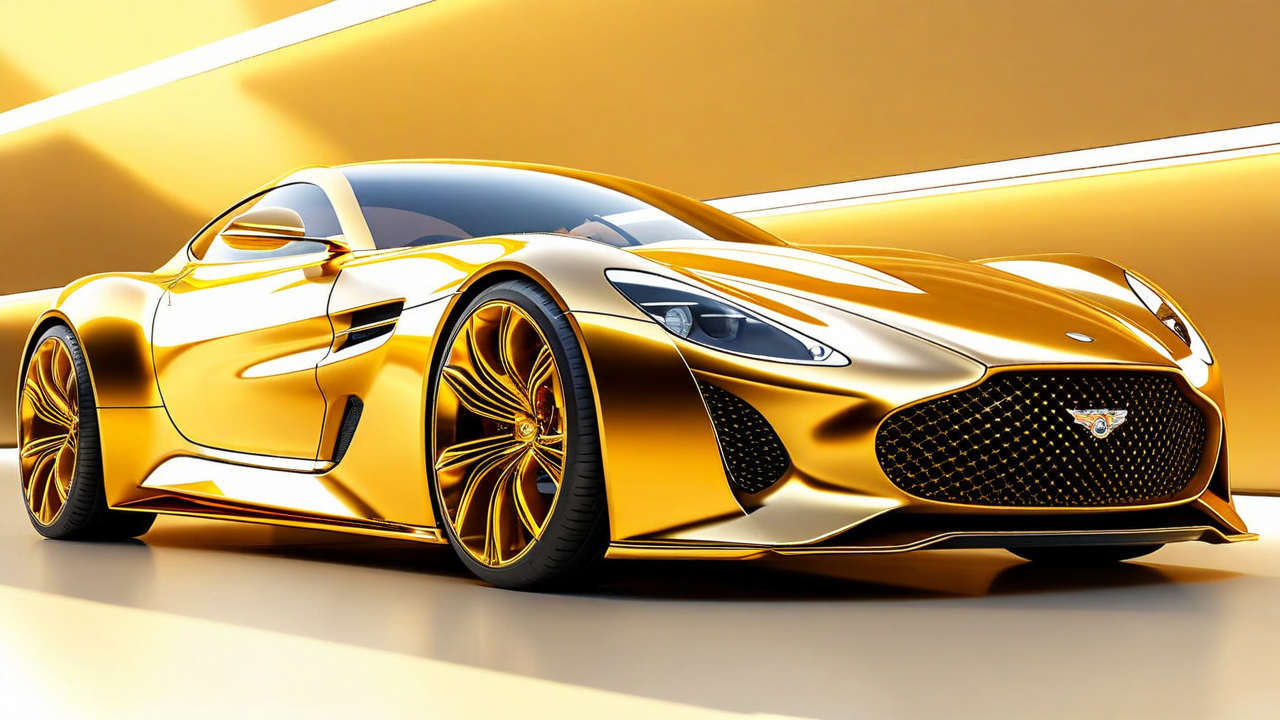

In [11]:
image_prompt = "Realistic image of a luxury fast golden car, sleek modern design, shiny metallic gold color, low angle view highlighting the curves and aerodynamic features, bright daylight with subtle shadows, high-resolution detail."
generate_image(prompt=image_prompt, seed=seed, output_image_name='luxury_car')

This is an example of how to use `generate_image_variation` function to generate a variation for a given image.

File exists


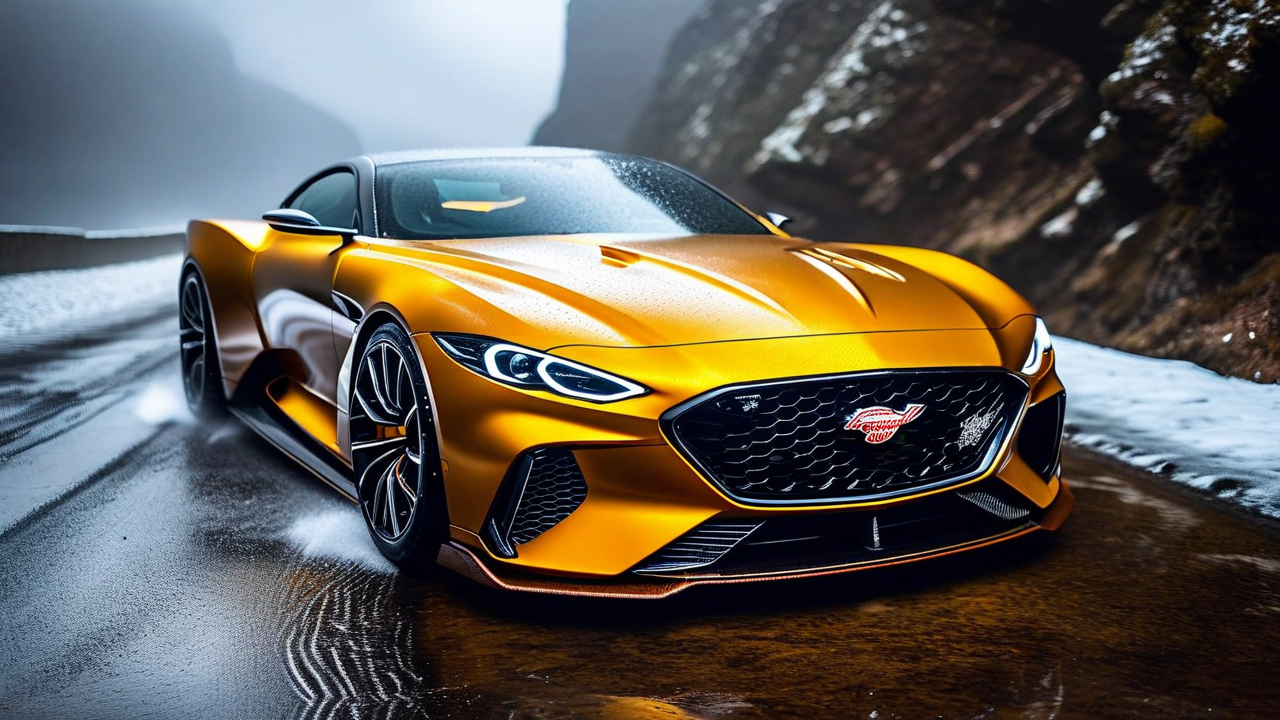

In [12]:
image_prompt_variation = "Another shoot from the car"
generate_image_variation(prompt=image_prompt_variation, seed=seed, output_image_name='luxury_car2',input_image_name='luxury_car')

We then use the image generated to generate the video

In [13]:
generate_video(video_prompt="zoom out", seed=seed, input_image_name='luxury_car', output_video_name="luxury_car")

File exists


Another video from the image generated with Amazon Nova Canvas Model

In [14]:
generate_video(video_prompt="zoom in", seed=seed, input_image_name='luxury_car2', output_video_name="luxury_car2")

File exists


### Demo: Enhance User Experience with Animated Product Images

Here we provide a simple application to hover over the image and play his respective video
(This code will open another tab with the application)

In [15]:
import tkinter as tk
from tkinter import *
import cv2
from PIL import Image, ImageTk

class VideoPlayer:
    def __init__(self, window):
        self.window = window
        self.window.title("Video Player")
        
        # Create frame to hold both canvases horizontally
        self.frame = Frame(window)
        self.frame.pack(expand=True, fill="both")
        
        # Initialize both videos and canvases
        self.videos = [
            {
                "image": "images/luxury_car.png", # The image to use
                "video": "videos/luxury_car.mp4", # His respective video
                "canvas": None,
                "vid": None,
                "is_playing": False,
                "photo": None,
                "thumbnail_photo": None,
                "width": 1280//2, # The width and height are adjustable
                "height": 720//2
            },
            {
                "image": "images/luxury_car2.png", # The second image to use
                "video": "videos/luxury_car2.mp4",
                "canvas": None,
                "vid": None,
                "is_playing": False,
                "photo": None,
                "thumbnail_photo": None,
                "width": 1280//2,
                "height": 720//2
            }
        ]
        
        # Setup each video player
        for i, video in enumerate(self.videos):
            # Create canvas with dimensions from videos list
            canvas = Canvas(self.frame, width=video["width"], height=video["height"])
            canvas.pack(side=LEFT, padx=10)
            video["canvas"] = canvas
            
            # Load and display thumbnail
            self.setup_thumbnail(i)
            
            # Bind hover events
            canvas.bind("<Enter>", lambda e, idx=i: self.start_video(idx))
            canvas.bind("<Leave>", lambda e, idx=i: self.stop_video(idx))
        
        self.delay = 15

    def setup_thumbnail(self, index):
        video = self.videos[index]
        # Load and resize thumbnail
        thumbnail = Image.open(video["image"])
        # Use dimensions from videos list
        thumbnail = thumbnail.resize((video["width"], video["height"]))
        video["thumbnail_photo"] = ImageTk.PhotoImage(thumbnail)
        
        # Display thumbnail
        video["canvas"].delete("all")
        video["canvas"].create_image(0, 0, image=video["thumbnail_photo"], anchor=NW)

    def start_video(self, index):
        video = self.videos[index]
        if not video["is_playing"]:
            video["vid"] = cv2.VideoCapture(video["video"])
            video["is_playing"] = True
            self.update_frame(index)

    def stop_video(self, index):
        video = self.videos[index]
        if video["vid"] is not None:
            video["vid"].release()
        video["is_playing"] = False
        self.setup_thumbnail(index)
            
    def update_frame(self, index):
        video = self.videos[index]
        if video["is_playing"]:
            ret, frame = video["vid"].read()
            if ret:
                # Convert frame from BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Resize frame using dimensions from videos list
                frame = cv2.resize(frame, (video["width"], video["height"]))
                
                # Convert frame to PhotoImage
                frame_image = Image.fromarray(frame)
                video["photo"] = ImageTk.PhotoImage(image=frame_image)
                
                # Clear canvas and show new frame
                video["canvas"].delete("all")
                video["canvas"].create_image(0, 0, image=video["photo"], anchor=NW)
                
                # Schedule next update
                self.window.after(self.delay, lambda: self.update_frame(index))
            else:
                # Video ended - restart video
                video["vid"].release()
                self.start_video(index)

    def __del__(self):
        for video in self.videos:
            if video["vid"] is not None:
                video["vid"].release()

# Create main window and start application
root = tk.Tk()
app = VideoPlayer(root)
root.mainloop()


2025-01-17 08:41:05.952 python[79357:103934892] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-17 08:41:05.952 python[79357:103934892] +[IMKInputSession subclass]: chose IMKInputSession_Modern


### Demo: Generating Longer Videos

The videos generated by Nova Reel can be chained together to make a longer video

To create longer videos we need to extract the last frame of the first video as an image, and then it to generate the next one. For this we are going to use libraries and tools outside of the native features of Amazon Nova models.

First, we need to generate the first video, we'll do that on the following cell:

In [16]:
# First generate a video
first_video_prompt = "First person view walking through light snowfall in a forest, sunlight through trees, dolly forward, cinematic"
first_video_name = "walking_forest"
generate_video(video_prompt=video_prompt, seed=seed, output_video_name=first_video_name)

File exists


We define a function to extract the last frame of the first video:

In [17]:
# Function to extract last frame
def extract_last_frame(video_path: str, output_path: str):
    """
    Extracts the last frame of a video file.

    Args:
        video_path (str): The local path to the video to extract the last frame from.
        output_path (str): The local path to save the extracted frame to.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Move to the last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)

    # Read the last frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if ret:
        # Save the last frame as an image
        cv2.imwrite(output_path, frame)
        print(f"Last frame saved as {output_path}")
    else:
        print("Error: Could not read the last frame.")

    # Release the video capture object
    cap.release()

We use that function to extract the last frame from the first video:

Last frame saved as images/walking_forest_last_frame.png


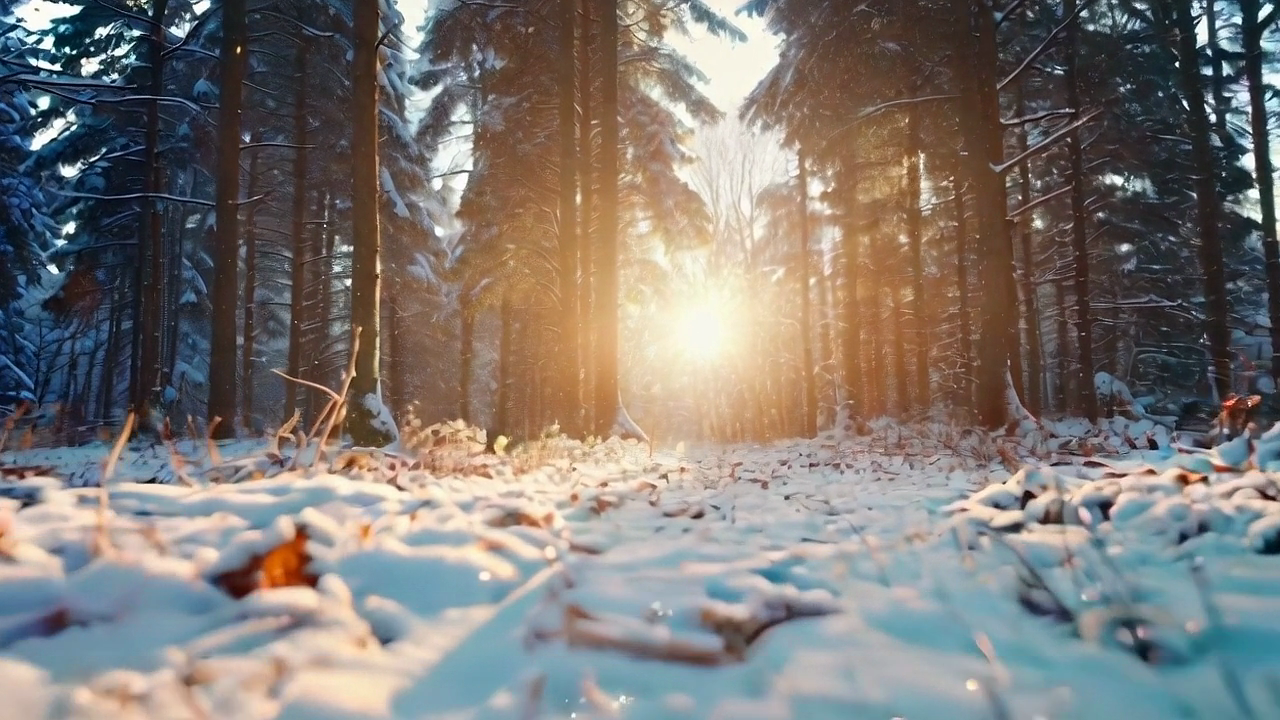

In [18]:
import os
from PIL import Image
from datetime import datetime

# Extract the last frame from the video
last_frame_name=f"{first_video_name}_last_frame"
last_frame_output_path = f"images/{last_frame_name}.png"
video_path = f'videos/{first_video_name}.mp4'
extract_last_frame(video_path=video_path,output_path=last_frame_output_path)

# Display the last frame
with Image.open(last_frame_output_path) as last_frame:
    last_frame.load()
    display(last_frame)


We then use that last frame as the input image to generate the second video:

In [19]:
# Generate the second video

second_video_prompt = "First person view, cinematic dolly forward shot as a majestic wolf enters the frame."
second_video_name="walking_forest_2"
#seed2=random.randint(0, 2147483648)
generate_video(video_prompt=second_video_prompt, seed=seed, input_image_name=last_frame_name, output_video_name=second_video_name)


File exists


And finally we need to stitch the two videos together to make the final video.
In the following cell we are definig a function for this purpose:

In [20]:
import os
#os.environ["IMAGEIO_FFMPEG_EXE"] = "~/anaconda3/bin/ffmpeg"
#os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin"
#os.environ["FFMPEG_BINARY"] = "/Users/actlyong/anaconda3/lib/python3.12/site-packages/ffmpeg"
#!echo $FFMPEG_BINARY

from moviepy import VideoFileClip, CompositeVideoClip

def stitch_videos(video1_path: str, video2_path: str, output_path: str):
    """
    Stitches two videos together and saves the result to a new file.

    Args:
        video1_path (str): The file path to the first video.
        video2_path (str): The file path to the second video.
        output_path (str): The file path to save the stitched video.
    """
    # Load the video clips
    clip1 = VideoFileClip(video1_path)
    clip2 = VideoFileClip(video2_path)

    final_clip = [
        clip1,
        clip2.with_start(clip1.duration),
    ]

    # Concatenate the clips
    final_clip = CompositeVideoClip(final_clip)

    # Write the result
    final_clip.write_videofile(output_path)

    # Clean up
    clip1.close()
    clip2.close()
    final_clip.close()

    print(f"Stitched video saved to {output_path}")

In [21]:
#!conda install imageio-ffmpeg -c conda-forge -y
#!pip install moviepy
#!pip install ffmpeg

In the following cell we are using the previously defined function to stitch the videos together:

In [22]:
# Stitch the videos

# Create output path for merged video
final_video_path = f"videos/{first_video_name}_merged_video.mp4"

# Stitch the two video generations together
first_video_path=f'videos/{first_video_name}.mp4'
second_video_path=f'videos/{second_video_name}.mp4'
stitch_videos(first_video_path, second_video_path, final_video_path)


{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 8800, 'fps': 24.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'handler_name': 'VideoHandler'}}], 'input_number': 0}], 'duration': 6.04, 'bitrate': 8803, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1280, 720], 'video_bitrate': 8800, 'video_fps': 24.0, 'video_duration': 6.04, 'video_n_frames': 144}
/Users/actlyong/anaconda3/bin/ffmpeg -i videos/walking_forest.mp4 -loglevel error -f image2pipe -vf scale=1280:720 -sws_flags bicubic -pix_fmt rgb24 -vcodec rawvideo -
{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'mino

MoviePy - Done !
MoviePy - video ready videos/walking_forest_merged_video.mp4
Stitched video saved to videos/walking_forest_merged_video.mp4


Visualization of the final_video

In [ ]:
Video(final_video_path)